# Advanced NLP Workshop

In this workshop, you will learn a number of advanced NLP techniques, with exercises based on a real-world dataset of tweets on #Telstra and #Optus.

**Installing required libraries.**

Install pyLDAvis library for interactive topic visualization dashboard.

In [4]:
!pip install pyLDAvis

Load libraries.

In [5]:
# Loading primary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# For text processing
import re
from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Load data

Load the two datasets (Download from LMS)

In [6]:
df_telstra = pd.read_excel("tp7_telco.xlsx", sheet_name='telstra')
df_optus = pd.read_excel("tp7_telco.xlsx", sheet_name='optus')

In [7]:
# display the column names of the datasets
df_optus.columns

Index(['date', 'content', 'likes', 'retweets', 'authorID', 'name', 'gender',
       'followers', 'following', 'nTweets', 'location', 'tweets', 'day'],
      dtype='object')

In [8]:
df_telstra.columns

Index(['date', 'content', 'likes', 'retweets', 'tweets', 'authorID', 'name',
       'gender', 'followers', 'following', 'nTweets', 'location', 'day'],
      dtype='object')

As the first step, we can select a subset of columns required for our analysis. This can be done based on your business requirement.


In [9]:
df_telstra = df_telstra[['day', 'content']]
df_optus = df_optus[['day', 'content']]

In [10]:
df_optus.head()

,day,content
0,2016-01-01,optus ill giv them a try wen i get home is tha...
1,2016-01-01,optus yeah that'll have to do
2,2016-01-01,optus hi are there problems with cable interne...
3,2016-01-01,optus ->ai
4,2016-01-01,optus /waves to esther y


In [11]:
df_telstra.head()

,day,content
0,2016-01-01,telstra runkeeper i went out for a run.
1,2016-01-01,telstra you too :)
2,2016-01-01,telstra here we are no voice service until at ...
3,2016-01-01,home internet down since yesterday. telstra sa...
4,2016-01-01,three times telstra has said there was an erro...


## Preprocessing

Preprocessing applies to both the datasets.  Instead of duplicating the worm ( as we have to do each step twice (for 2 datasets)), we can combine the two datasets, while keeping track of the original dataset. For that, we create a seperate column ('flag') in both datasets, named 'provider' to indicate the source dataset.

In [12]:
# Create a new flag column for both datasets
df_telstra['provider'] = 'telstra'
df_optus['provider'] = 'optus'

In [13]:
df_telstra.head()

,day,content,provider
0,2016-01-01,telstra runkeeper i went out for a run.,telstra
1,2016-01-01,telstra you too :),telstra
2,2016-01-01,telstra here we are no voice service until at ...,telstra
3,2016-01-01,home internet down since yesterday. telstra sa...,telstra
4,2016-01-01,three times telstra has said there was an erro...,telstra


In [14]:
# combine the 2 datasets
df = pd.concat([df_telstra, df_optus], ignore_index=True)

Now we run the preprocessing.

In [15]:
# Transform sentences into lowercase
df['content'] = df['content'].str.lower()

In [16]:
# Following command is just to visualize the processed dataframe
df.tail()

,day,content,provider
37587,2016-02-29,optus yes and every day since. i have been run...,optus
37588,2016-02-29,optus hi i've been having trouble with my 4g f...,optus
37589,2016-02-29,optus clever,optus
37590,2016-02-29,optus your store was not aware of the $40 deal...,optus
37591,2016-02-29,jozmosis optus that would disqualify a lot of ...,optus


Remove twitter user ids that are mentioned in the tweet text. We will use [regular expressions ](https://www.w3schools.com/python/python_regex.asp) to do this.  
In applying the regular expression, we use the string in the format r"regular-expression". This is to treat the regex as a raw string. Additional information on this can be found from [this stackoverflow question](https://stackoverflow.com/questions/4780088/what-does-preceding-a-string-literal-with-r-mean).

In [17]:
def remove_twitter_ids(tweet):
  mention_removed_tweet = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", str(tweet)) # remove any sequence of characters followed by '@' sign
  spaces_removed = re.sub(r"\s\s+", " ", str(mention_removed_tweet)) # remove multiple spaces
  return spaces_removed

df['content'] = df['content'].apply(remove_twitter_ids)
df.tail()

,day,content,provider
37587,2016-02-29,optus yes and every day since i have been runn...,optus
37588,2016-02-29,optus hi ive been having trouble with my 4g fo...,optus
37589,2016-02-29,optus clever,optus
37590,2016-02-29,optus your store was not aware of the 40 deal ...,optus
37591,2016-02-29,jozmosis optus that would disqualify a lot of ...,optus


In [18]:
# How does above function works?
# Take any tweet that has mentions in it. e.g., https://twitter.com/DavidLKeating/status/1251253645431144457
twt = "Canada just ordered #masks4all for flights. We need this on all US flights NOW. What are we waiting for @SecElaineChao @AmericanAir @Delta @SouthwestAir @united @AlaskaAir @FAANews ??? @jeremyphoward update"
out_twt = remove_twitter_ids(twt)
print(out_twt)

Canada just ordered masks4all for flights We need this on all US flights NOW What are we waiting for update


### Duplicate removal

It is essential we check for duplicates. Because, the tweets are extracted from Twitter API and it is likely the same tweet repeats multiple times.  
We can utilize pandas drop_duplicates() function. [Link to API](https://pandas.pydata.org/pandas-docs/version/0.24.2/reference/api/pandas.DataFrame.drop_duplicates.html)

In [19]:
# Check duplicate tweets count
duplicate_count = len(df['content'])-len(df['content'].drop_duplicates())
print('duplicate count:', duplicate_count)
print('total records before remove duplicates:', df.shape[0])

duplicate count: 1215
total records before remove duplicates: 37592


In [20]:
# drop duplicates (keep the last tweet of each of the duplicates)
df = df.drop_duplicates(subset='content', keep="first")
print('updated record count:', df.shape[0])

updated record count: 36377


Now we will remove all punctuation, retaining just the text.




In [21]:
# Remove punctuations
df['content'] = df['content'].str.replace(r'[^\w\s]','')  # This is the use of regular expressions.
df.tail()

<ipython-input-21-667e04136faf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['content'].str.replace(r'[^\w\s]','')  # This is the use of regular expressions.


,day,content,provider
37587,2016-02-29,optus yes and every day since i have been runn...,optus
37588,2016-02-29,optus hi ive been having trouble with my 4g fo...,optus
37589,2016-02-29,optus clever,optus
37590,2016-02-29,optus your store was not aware of the 40 deal ...,optus
37591,2016-02-29,jozmosis optus that would disqualify a lot of ...,optus


### Stop words and domain related word removal

Now let's conduct further text pre- processing using NLTK library as we did in the first NLP workshop. First, remove stopwords.

In [22]:
#Remove stop words
# Load NLTK library
import nltk

# Download the stopwords to the nltk library
nltk.download('stopwords')

# Load the stopwords
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
# get the list of all stopwords from the library
stop = stopwords.words('english')

In [24]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Note that the term 'not' is in the stop word list. This will have a negative impact on sentiment analysis. However, if the NLP technique is topic modeling,  there will be no such impact. It is important to keep this mind, drop or retain words depending on the goal of your exercise.  
For this case, we will remove the term 'not' from the stopword list.

In [25]:
stop.remove('not')

In [26]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

In [27]:
# Remove the words in 'stop' list
def remove_stop_words(tweet):
  tokens = tweet.split()
  stop_removed_tokens = [t for t in tokens if t not in stop]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string

df['content'] = df['content'].apply(remove_stop_words)
df.tail(5)

,day,content,provider
37587,2016-02-29,optus yes every day since running isolation te...,optus
37588,2016-02-29,optus hi ive trouble 4g last days dont know iv...,optus
37589,2016-02-29,optus clever,optus
37590,2016-02-29,optus store not aware 40 deal 12 month byo dea...,optus
37591,2016-02-29,jozmosis optus would disqualify lot push notif...,optus


In [28]:
# How above function works?
def remove_stop_words(tweet):
  tokens = tweet.split()
  stop_removed_tokens = [t for t in tokens if t not in stop]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string

txt = "you are the first person."
remove_stop_words(txt)

'first person.'

In [29]:
# For your knowledge: Same above function can be written as a lambda function
# df['content'] = df['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

### Standardization of tweets

We shall use stemming to standardize tweets.  
[Stemming](https://en.wikipedia.org/wiki/Stemming) is the removal of prefix, suffix etc, to derive the base form of a word. We will use the NLTK library.

In [30]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stemming_function(sent):
  word_list = sent.split()
  stemmed_word_list = [stemmer.stem(word) for word in word_list]
  stemmed_sentence = " ".join(stemmed_word_list)
  return stemmed_sentence

df['content_stem'] = df['content'].apply(stemming_function)

In [31]:
# Compare the content vs. stemmed content
df[['content', 'content_stem']].tail(10)

,content,content_stem
37582,optus net pisses,optu net piss
37583,bulldogchris gus10gould juzweezy case point lo...,bulldogchri gus10gould juzweezi case point loo...
37584,leaveforthecup optus yeah good luck,leaveforthecup optu yeah good luck
37585,dragonsfan1988 gus10gould juzweezy foxtel dead...,dragonsfan1988 gus10gould juzweezi foxtel dead...
37586,dragonsfan1988 gus10gould foxtel overpriced nr...,dragonsfan1988 gus10gould foxtel overpr nrl re...
37587,optus yes every day since running isolation te...,optu ye everi day sinc run isol test 2 week pl...
37588,optus hi ive trouble 4g last days dont know iv...,optu hi ive troubl 4g last day dont know ive p...
37589,optus clever,optu clever
37590,optus store not aware 40 deal 12 month byo dea...,optu store not awar 40 deal 12 month byo deal ...
37591,jozmosis optus would disqualify lot push notif...,jozmosi optu would disqualifi lot push notif g...


The stemming has turned term 'optus' to 'optu', thus, stemming has not deemed expected results in this context.  Thereby, we will go ahead with original content without any standardization.   
You may attempt to lemmatize and see if you can improve the results.

## Word frequency analysis

Let us look at the most occuring words and the least occuring words in our tweet dataset.

In [32]:
# Create a word frequency series. (This is a pandas series)
word_frequency = pd.Series(' '.join(df['content']).split()).value_counts()

In [33]:
# Look at the top 10 words (you can write either word_frequency[:10] or word_frequency[0:10]. Both give the same result.)
word_frequency[:10]

,count
telstra,27434
optus,12871
not,3994
internet,3190
phone,2775
get,2668
service,2641
im,2258
thanks,2210
call,1992


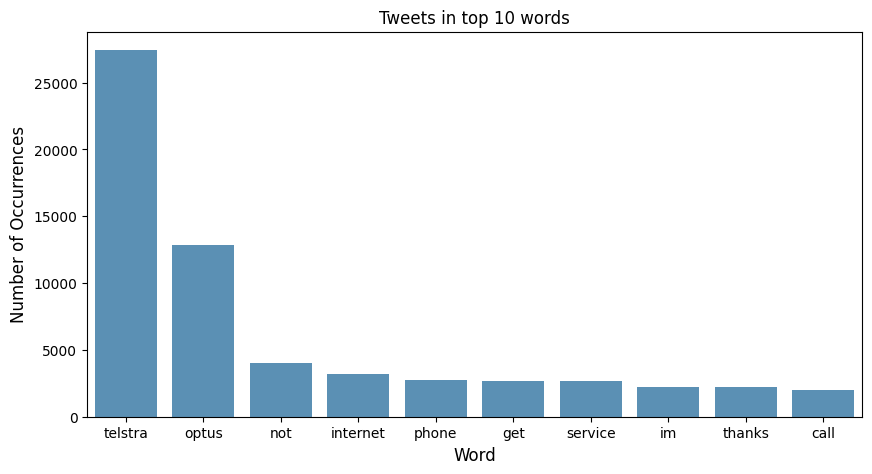

In [34]:
# Visualize the top word counts

word_count  = word_frequency
word_count = word_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(x=word_count.index, y=word_count.values, alpha=0.8)
plt.title('Tweets in top 10 words')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.show()

We will now visualize the text corpus that we created after pre-processing to get insights on the most frequently used words.

In [35]:
from PIL import Image
from wordcloud import WordCloud

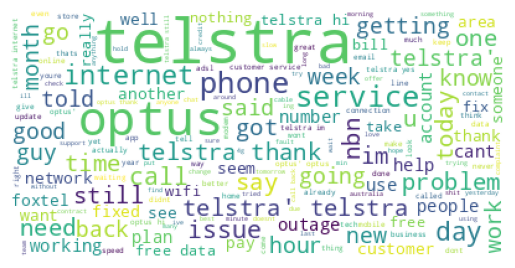

In [36]:
corpus = list(df['content'])

wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Insight**  
From the word cloud we could identify that terms telstra and optus has been mentioned frequently. But this is expected - not so much an insight. Therefore, you may remove high frequent yet non-insightful words alongside the twitter specific words.

### Remove common words

Let's  remove context specific words and the most common words from the tweets.

The tweets extracted are from the hashtags @telstra and @optus, these keywords will appear in most tweets. Let's  add those keywords to the set of words to be removed.  
We can extend the new_words list with those additional keywords, which you may think will be widely used due to the area/domain the tweets were extracted.

In [37]:
# Creating a list of custom stopwords
new_words_to_remove = ["pic", "twitter", "com", "telstra", "optus"]

In [38]:
# Remove common words
# We will use lambda function here.
df['content'] = df['content'].apply(lambda x: " ".join(x for x in x.split() if x not in new_words_to_remove))
df.head(5)

,day,content,provider,content_stem
0,2016-01-01,runkeeper went run,telstra,telstra runkeep went run
1,2016-01-01,,telstra,telstra
2,2016-01-01,voice service least mon box door still open,telstra,telstra voic servic least mon box door still open
3,2016-01-01,home internet since yesterday says fixed 6pm 4...,telstra,home internet sinc yesterday telstra say fix 6...
4,2016-01-01,three times said error porting said completed ...,telstra,three time telstra said error port said comple...


Exercise: try to replicate lambda function above as a python function.

We will re-attempt to compose a frequency appearing word list.

In [39]:
# Create a word frequency series. (This is a pandas series)
word_frequency = pd.Series(' '.join(df['content']).split()).value_counts()

In [40]:
# Look at the top 10 words (you can write either word_frequency[:10] or word_frequency[0:10]. Both give the same result.)
word_frequency[:10]

,count
not,3994
internet,3190
phone,2775
get,2668
service,2641
im,2258
thanks,2210
call,1992
still,1968
data,1761


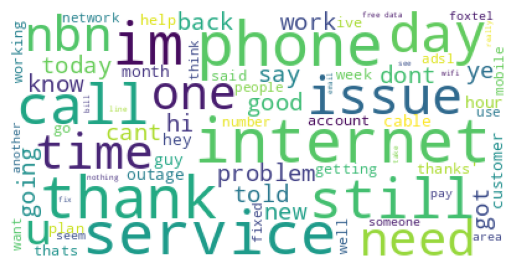

In [41]:
corpus = list(df['content'])

wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Bigrams and Trigrams

The following commands will extract bigrams from the tweet dataset.  
From here onwards, we will isolate tweets for each provider to conduct a comparative analysis.

In [42]:
# Seperate the two datasets by using pandas filtering mechanism.
df_telstra_processed = df.loc[df['provider'] == 'telstra']
df_optus_processed = df.loc[df['provider'] == 'optus']

### Bigrams

We will use CountVectorizer object from sklearn to generate bi-grams and tri-grams. [Link to API](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)  

You may refer [this StackoverFlow explanation](https://stackoverflow.com/questions/24005762/understanding-the-ngram-range-argument-in-a-countvectorizer-in-sklearn) to understand ngram_range parameter.

In [43]:
# This function will generate most frequently occuring Bi-grams
def get_ngrams(corpus, ngram_range=(2, 2)):

    # Create CountVectorizer object from sklearn library with bigrams
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)

    # Create BoW feature representation using word frequency
    bag_of_words = vec1.transform(corpus)

    # compute sum of words
    sum_words = bag_of_words.sum(axis=0)

    # create (word, frequency) tuples for bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

Try out an example to see how this  function works.

In [44]:
txts = ['John likes to watch movies', 'Mary likes movies too', 'Mary also likes to watch football games']
get_ngrams(txts, ngram_range=(4, 4))

[('john likes to watch', 1),
 ('likes to watch movies', 1),
 ('mary likes movies too', 1),
 ('mary also likes to', 1),
 ('also likes to watch', 1),
 ('likes to watch football', 1),
 ('to watch football games', 1)]

In [45]:
bigrams_telstra = get_ngrams(df_telstra_processed['content'].tolist(), ngram_range=(2, 2))
bigrams_optus = get_ngrams(df_optus_processed['content'].tolist(), ngram_range=(2, 2))

In [46]:
bigrams_telstra

[('free data', 441),
 ('customer service', 275),
 ('call back', 186),
 ('not working', 182),
 ('im not', 179),
 ('data day', 136),
 ('still waiting', 131),
 ('still not', 128),
 ('mobile data', 125),
 ('cable internet', 117),
 ('phone line', 116),
 ('call centre', 115),
 ('home phone', 101),
 ('dont know', 97),
 ('internet connection', 93),
 ('tech support', 93),
 ('live chat', 91),
 ('cant get', 89),
 ('looks like', 88),
 ('case manager', 88),
 ('not sure', 88),
 ('new phone', 84),
 ('24 hours', 82),
 ('not good', 82),
 ('last week', 82),
 ('service status', 81),
 ('cant even', 81),
 ('last night', 78),
 ('internet service', 74),
 ('whats going', 74),
 ('not happy', 73),
 ('phone calls', 67),
 ('doesnt work', 65),
 ('not even', 64),
 ('reference number', 63),
 ('dont want', 63),
 ('phone call', 60),
 ('data today', 60),
 ('im still', 58),
 ('status page', 57),
 ('phone internet', 57),
 ('isnt working', 57),
 ('new modem', 54),
 ('get free', 54),
 ('trying get', 54),
 ('unlimited data'

Convert bigrams of both datasets to a dataframe with column names bi-gram and frequency.

In [47]:
bigrams_telstra_df = pd.DataFrame(bigrams_telstra)
bigrams_telstra_df.columns=["Bi-gram", "Freq"]

bigrams_optus_df = pd.DataFrame(bigrams_optus)
bigrams_optus_df.columns=["Bi-gram", "Freq"]

<ipython-input-48-3b18c3a5b5db>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  h.set_xticklabels(h.get_xticklabels(), rotation=90)  # here rotation parameter shows the angle of your x-axis labels


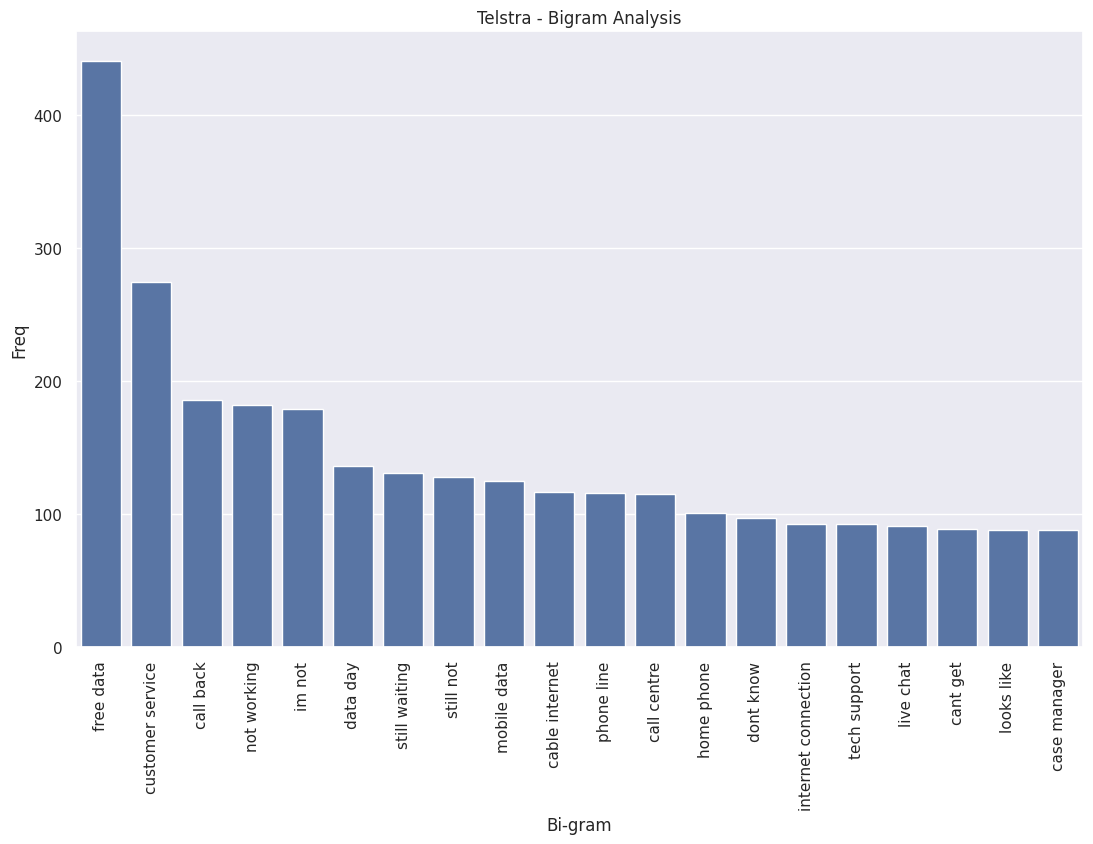

In [48]:
# Barplot of most freq Bi-grams
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=bigrams_telstra_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)  # here rotation parameter shows the angle of your x-axis labels
plt.title('Telstra - Bigram Analysis')
plt.show()

**Insights**:  
The bigram 'data day' refers to an event. After a series of outages, Telstra declared a free data day as a compensation. Notice how bigrams can be used to detect such events as well as topics/themes specific to the domain.

<ipython-input-49-f275c309d700>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  h.set_xticklabels(h.get_xticklabels(), rotation=90)


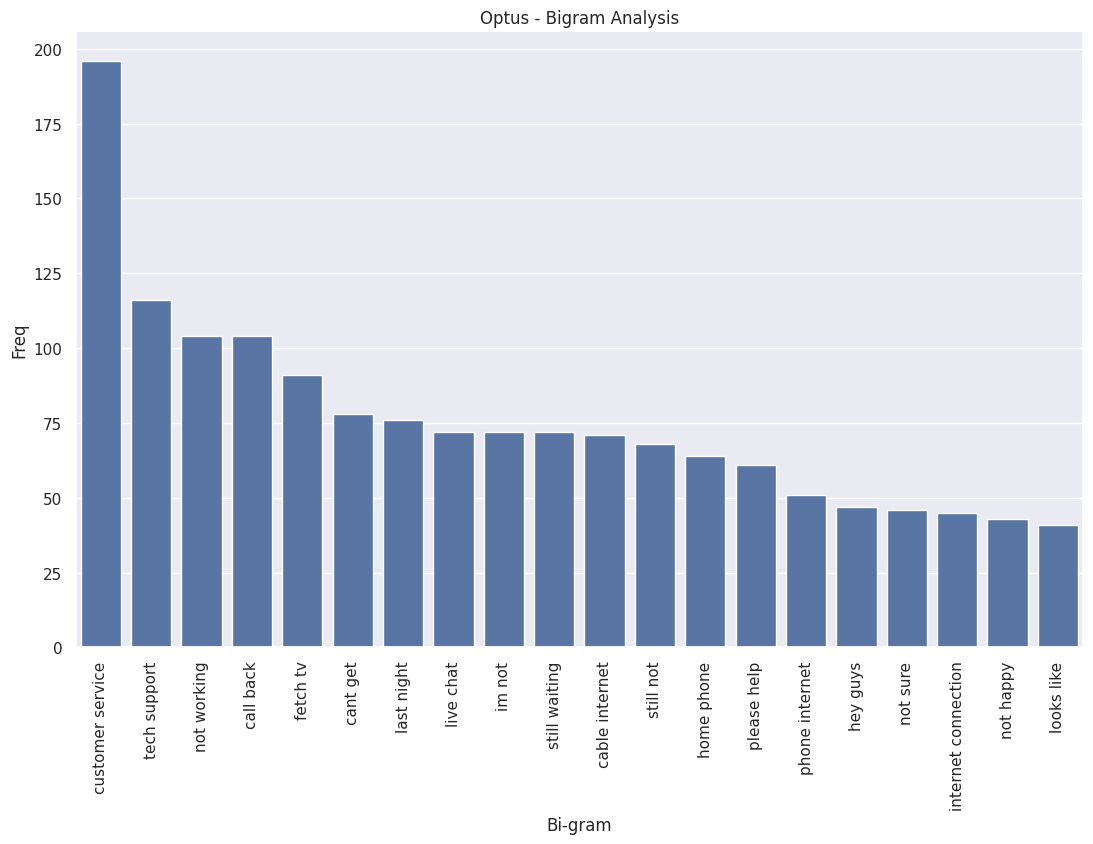

In [49]:
# Barplot of most freq Bi-grams for optus
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=bigrams_optus_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title('Optus - Bigram Analysis')
plt.show()

**Insights:**  
Observe that in Optus dataset, there are many words related to sport which were not prominent in Telstra data. Bigram frequencies can be used to differentiate and compare topics of interest.

### Trigrams

Let's now attempt trigrams.

In [50]:
trigrams_telstra = get_ngrams(df_telstra_processed['content'].tolist(), ngram_range=(3, 3))
trigrams_optus = get_ngrams(df_optus_processed['content'].tolist(), ngram_range=(3, 3))

Convert tri-grams of both datasets to a dataframe with column names tri-gram and frequency.

In [51]:
trigrams_telstra_df = pd.DataFrame(trigrams_telstra)
trigrams_telstra_df.columns=["Tri-gram", "Freq"]

trigrams_optus_df = pd.DataFrame(trigrams_optus)
trigrams_optus_df.columns=["Tri-gram", "Freq"]

<ipython-input-52-76d98bcd323f>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  h.set_xticklabels(h.get_xticklabels(), rotation=90)


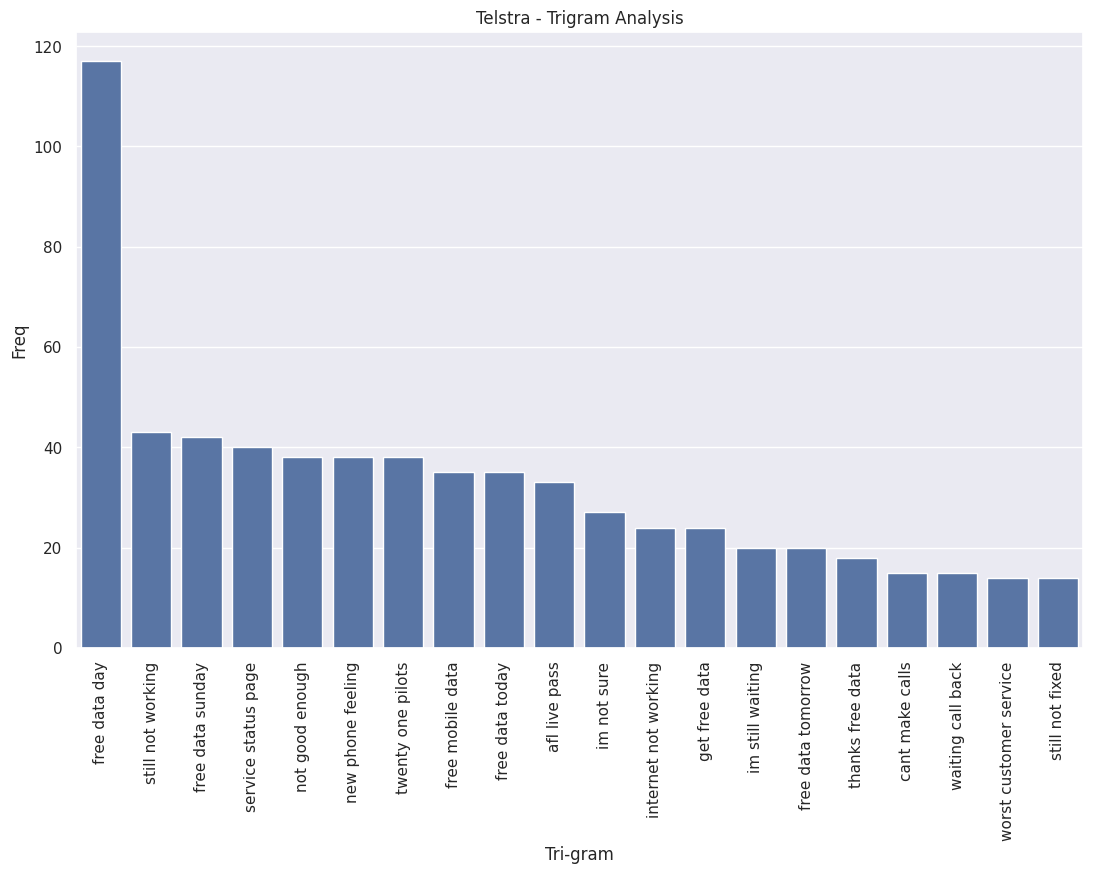

In [52]:
# Barplot of most freq Tri-grams
top_trigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=trigrams_telstra_df[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title('Telstra - Trigram Analysis')
plt.show()

<ipython-input-53-2de30eaf1ba9>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  h.set_xticklabels(h.get_xticklabels(), rotation=90)


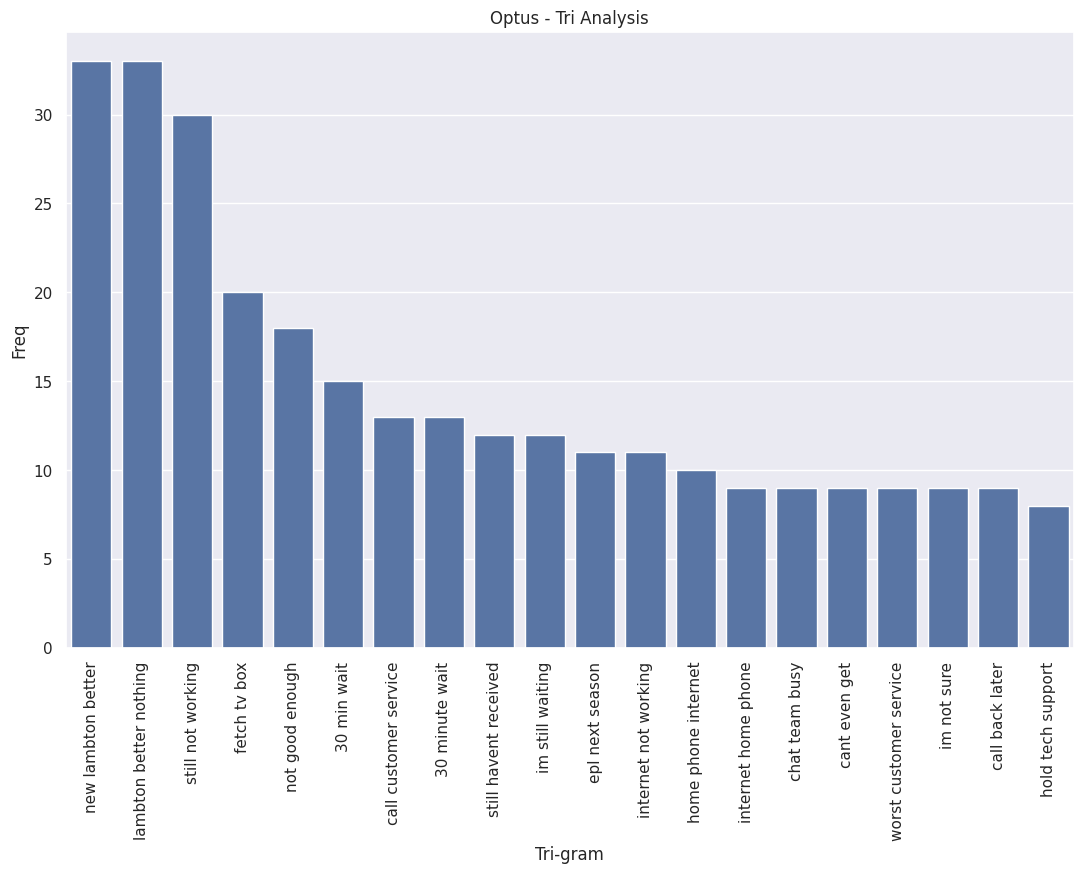

In [53]:
# Barplot of most freq Tri-grams
top_trigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=trigrams_optus_df[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title('Optus - Tri Analysis')
plt.show()

Can you determine new insights from Trigram plots?

## Temporal Analysis

Now let's attempt to explore temporal patterns in the two datasets.

In [54]:
# Group the twitter datasets based on the date field and get the count per each day.
df_telstra_date_wise = df_telstra_processed.groupby(['day'])['content'].count().reset_index(name='tweet_count_telstra').set_index('day')
df_optus_date_wise = df_optus_processed.groupby(['day'])['content'].count().reset_index(name='tweet_count_optus').set_index('day')

In [55]:
df_telstra_date_wise.head()

,tweet_count_telstra
day,
2016-01-01,147
2016-01-02,518
2016-01-03,418
2016-01-04,696
2016-01-05,257


In [56]:
df_optus_date_wise.tail()

,tweet_count_optus
day,
2016-02-25,160
2016-02-26,220
2016-02-27,140
2016-02-28,100
2016-02-29,155


When plotting with python, we can change the size of the plot and save it as a figure in your workspace.  
* Change size: plt.figure(figsize=(width, length)) # width and length are in inches  
* Save the image: plt.savefig(filename, dpi)  # dpi is the resolution in pixels

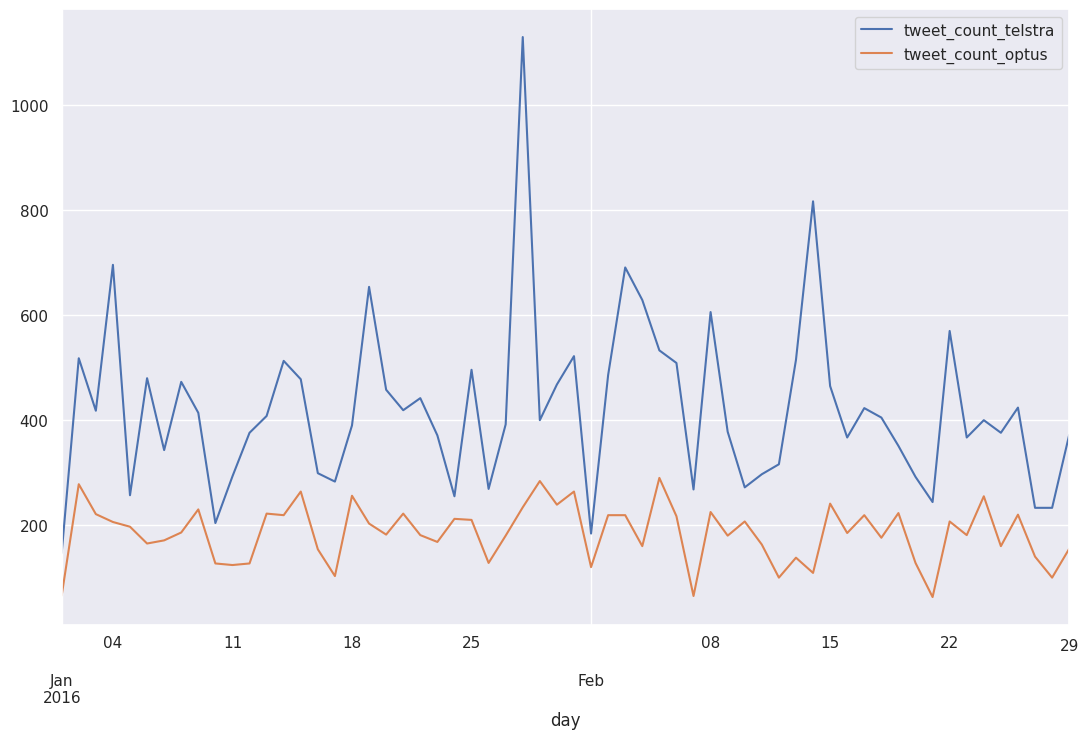

In [57]:
ax = df_telstra_date_wise.plot()
df_optus_date_wise.plot(ax=ax)
plt.savefig('temporal_analysis_v2.png', dpi=800)

Output image is saved in files tab. You can right click on the image and download it to your computer for further analysis.

Insights: How would you describe the two line plots? Any actionable insights?  
Exerciese: Go through the actual Telstra dataset on 2018-01-28, can you explain this spike in tweet count?

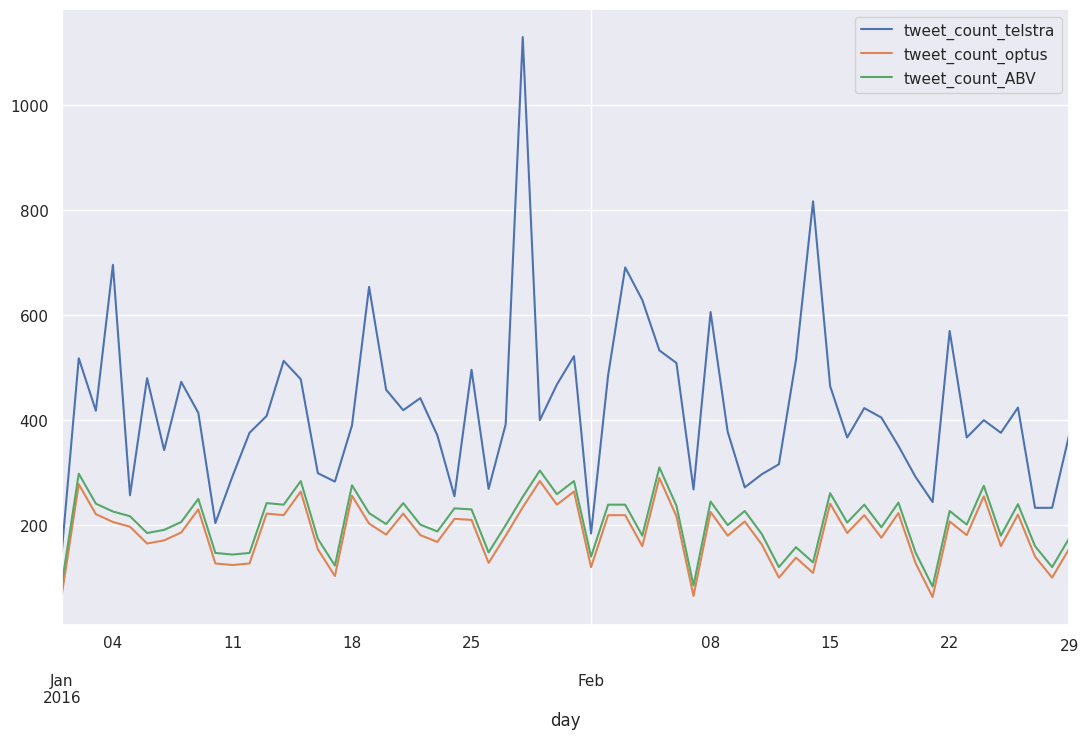

In [58]:
# this is a helper code if you have 3 or more dataframes to compare with.
df_ABC_date_wise =df_optus_date_wise.copy()
df_ABC_date_wise['tweet_count_ABV'] = df_ABC_date_wise['tweet_count_optus'] + 20
del df_ABC_date_wise['tweet_count_optus']

ax = df_telstra_date_wise.plot()
df_optus_date_wise.plot(ax=ax)
df_ABC_date_wise.plot(ax=ax)
plt.savefig('temporal_analysis_v3.png', dpi=800)

## Sentiment Analysis

Analyse sentiments for each tweet, aggregate into the sentiment of particular day and derive a sentiment timeline.

In [59]:
# Extract sentiments from the tweets (This should take some time because we run this to the entire dataset.)
df['sentiment'] = df['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [60]:
# Display first 50 tweets with respective sentiment value
df[['content', 'sentiment']].head(50)

,content,sentiment
0,runkeeper went run,0.000000
1,,0.000000
2,voice service least mon box door still open,-0.150000
3,home internet since yesterday says fixed 6pm 4...,0.100000
4,three times said error porting said completed ...,0.000000
5,last six weeks ed continually porting number a...,0.000000
6,already,0.000000
7,per tweet service restored 6pm 4th jan ridiculous,-0.333333
8,bilis nang hahahaha,0.200000
9,awesome thanks nye text im worried im missing ...,0.220000


Again we will conduct invididual analysis for both telcom providers.

In [61]:
df_telstra_processed = df.loc[df['provider'] == 'telstra']
df_optus_processed = df.loc[df['provider'] == 'optus']

Aggregate the sentiment value (using mean) for each provider

In [62]:
df_telstra_processed

,day,content,provider,content_stem,sentiment
0,2016-01-01,runkeeper went run,telstra,telstra runkeep went run,0.000
1,2016-01-01,,telstra,telstra,0.000
2,2016-01-01,voice service least mon box door still open,telstra,telstra voic servic least mon box door still open,-0.150
3,2016-01-01,home internet since yesterday says fixed 6pm 4...,telstra,home internet sinc yesterday telstra say fix 6...,0.100
4,2016-01-01,three times said error porting said completed ...,telstra,three time telstra said error port said comple...,0.000
...,...,...,...,...,...
25567,2016-02-29,stop mobile redirecting home phone windows pho...,telstra,telstra stop mobil redirect home phone window ...,0.000
25568,2016-02-29,gg ed thegmunay,telstra,gg telstra ed thegmunay,0.000
25569,2016-02-29,get shit together ffs twice today internet died,telstra,telstra get shit togeth ff twice today interne...,-0.200
25570,2016-02-29,yeh technical error explanation told one date ...,telstra,telstra yeh technic error explan told one date...,0.125


In [63]:
df_telstra_processed.groupby(['day'])['sentiment'].mean()

,sentiment
day,
2016-01-01,0.003838
2016-01-02,0.028647
2016-01-03,0.066871
2016-01-04,0.043939
2016-01-05,0.032759
2016-01-06,0.009095
2016-01-07,0.016708
2016-01-08,0.031807
2016-01-09,0.038777


In [64]:
df_senti_telstra_date_wise = df_telstra_processed.groupby(['day'])['sentiment'].mean().reset_index(name='mean_sentiment_telstra').set_index('day')
df_senti_optus_date_wise = df_optus_processed.groupby(['day'])['sentiment'].mean().reset_index(name='mean_sentiment_optus').set_index('day')

Plot sentiment over time.

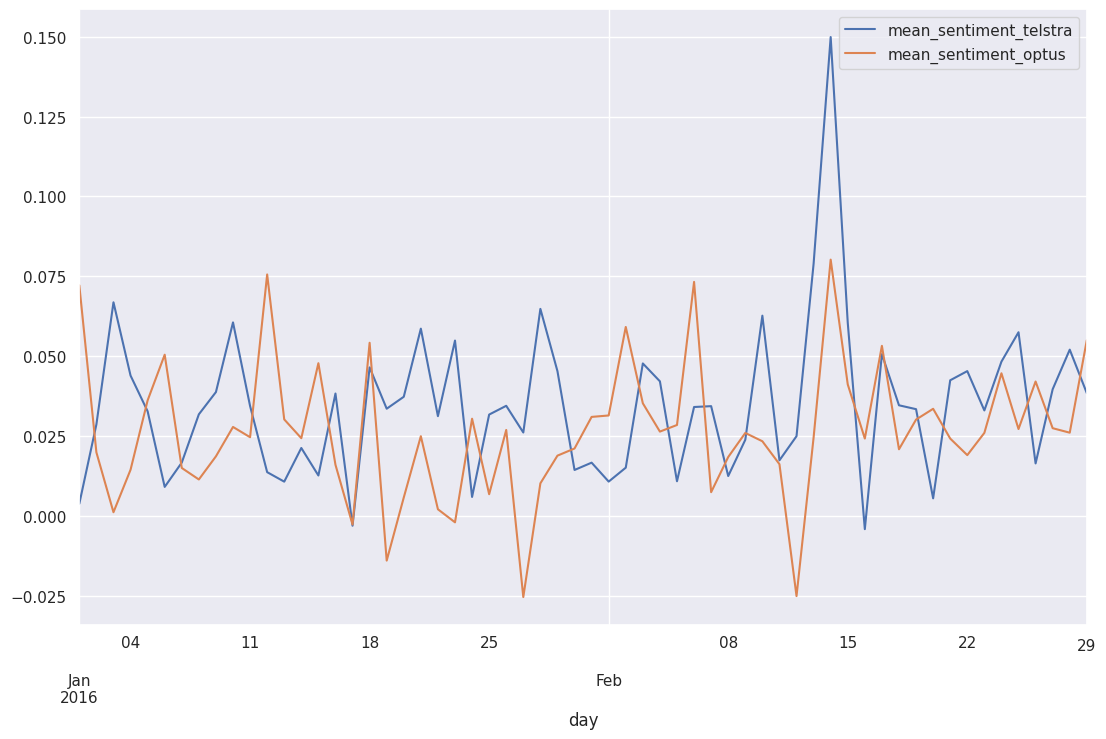

In [65]:
# Plot twitter sentimet timeline over each provider
ax = df_senti_telstra_date_wise.plot()
df_senti_optus_date_wise.plot(ax=ax)
plt.savefig('temporal_sentiment_v2.png', dpi=800)

**Insights:**   
When deriving insights you can refer to days with significant sentiment scores (peaks) and explore the tweets to identify what event has led to positive/negative sentiment.

## Topic Modeling

We will conduct a topic modeling for one of the twitter datasets here (Telstra).  
It is possible to conduct topic modeling using single words, bigrams, trigrams or n-grams.  
Will be using a topic modeling algorithm named - LDA (Latent Dirichlet Allocation) for this task.

In [66]:
# Setting up the environment for LDA algorithm.

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


In [67]:
# Filter the dataset of the telstra only.
df_telstra_processed = df.loc[df['provider'] == 'telstra']

Now we will create the text corpus.  


In [68]:
# Convert the tweets as the text corpus.
corpus = list(df_telstra_processed['content'])

In [69]:
corpus[:5]

['runkeeper went run',
 '',
 'voice service least mon box door still open',
 'home internet since yesterday says fixed 6pm 4jan five days areyoujoking pleaseexplain',
 'three times said error porting said completed wasnt cancelled']

In [70]:
# Tokenization
telstra_texts = [[word for word in str(document).split()] for document in corpus]

In [71]:
telstra_texts[:5]

[['runkeeper', 'went', 'run'],
 [],
 ['voice', 'service', 'least', 'mon', 'box', 'door', 'still', 'open'],
 ['home',
  'internet',
  'since',
  'yesterday',
  'says',
  'fixed',
  '6pm',
  '4jan',
  'five',
  'days',
  'areyoujoking',
  'pleaseexplain'],
 ['three',
  'times',
  'said',
  'error',
  'porting',
  'said',
  'completed',
  'wasnt',
  'cancelled']]

In [72]:
# Create a dictionary based on the tokanized words of all the tweets.
dictionary = corpora.Dictionary(telstra_texts)

# Save the above dictionary as a local file for LDA model to access.
dictionary.save(os.path.join(TEMP_FOLDER, 'telstra.dict'))

When creating the dictionary, each tweet (document) is alphabetically sorted before composing the dictionary.

In [73]:
print(telstra_texts[0])
print('alphabetically sorted', sorted(telstra_texts[0]))

['runkeeper', 'went', 'run']
alphabetically sorted ['run', 'runkeeper', 'went']


In [74]:
print(telstra_texts[1])
print('alphabetically sorted', sorted(telstra_texts[1]))

[]
alphabetically sorted []


In [75]:
# Print the dictionary
print(dictionary.token2id)

{'run': 0, 'runkeeper': 1, 'went': 2, 'box': 3, 'door': 4, 'least': 5, 'mon': 6, 'open': 7, 'service': 8, 'still': 9, 'voice': 10, '4jan': 11, '6pm': 12, 'areyoujoking': 13, 'days': 14, 'five': 15, 'fixed': 16, 'home': 17, 'internet': 18, 'pleaseexplain': 19, 'says': 20, 'since': 21, 'yesterday': 22, 'cancelled': 23, 'completed': 24, 'error': 25, 'porting': 26, 'said': 27, 'three': 28, 'times': 29, 'wasnt': 30, 'amaysim': 31, 'continually': 32, 'ed': 33, 'joke': 34, 'last': 35, 'number': 36, 'six': 37, 'weeks': 38, 'already': 39, '4th': 40, 'jan': 41, 'per': 42, 'restored': 43, 'ridiculous': 44, 'tweet': 45, 'bilis': 46, 'hahahaha': 47, 'nang': 48, 'awesome': 49, 'friends': 50, 'future': 51, 'get': 52, 'im': 53, 'missing': 54, 'nye': 55, 'offers': 56, 'text': 57, 'thanks': 58, 'worried': 59, 'bigpond': 60, 'bill': 61, 'charged': 62, 'double': 63, 'find': 64, 'ill': 65, 'movie': 66, 'next': 67, '24': 68, 'gone': 69, 'hit': 70, 'hours': 71, 'long': 72, 'something': 73, 'take': 74, 'trans

In [76]:
# Convert the text dictionary to bag of words model
corpus = [dictionary.doc2bow(text) for text in telstra_texts]

Can you explain this output?

In [77]:
tweet_id = 0
print(telstra_texts[tweet_id]) # each tweet converted to tokens
print(dictionary.doc2bow(telstra_texts[tweet_id])) # each token is represented as a id from a dictionary

['runkeeper', 'went', 'run']
[(0, 1), (1, 1), (2, 1)]


### Generate the topic model

Recall we initially loaded models library from gensim.  
(from gensim import corpora, models, similarities)

In [78]:
# Construct TF-IDF features from the dictionary.
tfidf = models.TfidfModel(corpus)

In [79]:
# Transform the tweets as TF-IDF feature vectors
corpus_tfidf = tfidf[corpus]

We need to define how many topics we capture through LDA.

In [80]:
total_topics = 40

Below code will build the LDA topic model.   
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.



In [81]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.  
You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.





In [82]:
# Print the Keyword in the 10 topics
lda.show_topics(total_topics, num_words=6)

[(0,
  '0.083*"na" + 0.054*"sa" + 0.042*"ang" + 0.041*"ng" + 0.035*"sale" + 0.029*"turnbullmalcolm"'),
 (1,
  '0.076*"wait" + 0.052*"right" + 0.049*"week" + 0.048*"fix" + 0.037*"around" + 0.031*"cannot"'),
 (2,
  '0.062*"hold" + 0.048*"id" + 0.047*"speeds" + 0.034*"response" + 0.027*"5" + 0.024*"media"'),
 (3,
  '0.075*"3" + 0.058*"hours" + 0.035*"days" + 0.028*"4" + 0.028*"without" + 0.025*"24"'),
 (4,
  '0.078*"bill" + 0.037*"house" + 0.030*"wrong" + 0.029*"address" + 0.027*"big" + 0.026*"pls"'),
 (5,
  '0.074*"waiting" + 0.053*"long" + 0.051*"sim" + 0.037*"still" + 0.025*"take" + 0.023*"call"'),
 (6,
  '0.067*"network" + 0.057*"mobile" + 0.052*"since" + 0.042*"account" + 0.041*"morning" + 0.032*"fine"'),
 (7,
  '0.072*"outage" + 0.063*"foxtel" + 0.054*"whats" + 0.048*"area" + 0.033*"internet" + 0.031*"service"'),
 (8,
  '0.052*"yeah" + 0.051*"problems" + 0.049*"australia" + 0.037*"due" + 0.036*"internet" + 0.027*"start"'),
 (9,
  '0.063*"another" + 0.040*"ok" + 0.034*"oh" + 0.031*"f

How will you interpret this?  
Assume a topic is a represented as '0.020*"nbn" + 0.010*"thanks" + 0.009*"turnbullmalcolm" + 0.009*"mobile" + 0.009*"copper" + 0.008*"buy"'  
  
It means the top 6 keywords that contribute to this topic are: nbn, thanks, turnbullmalcolm, mobile, copper, buy and the weight of ‘nbn’ on topic 5 is 0.020.  
  
The weights reflect how important a keyword is to that topic.  

Looking at these keywords, can you guess what this topic could be? You may summarise it as nbn connectivity (or more specifically Turnbull's decision as Telecommunications Minister to continue using the copper network for the NBN).  

Likewise, can you go through the remaining keyword subsets and infer each topic?  







### Interactive topic analyzer

In [83]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
37    -4.767144  1.552870       1        1  11.897816
24    -5.708109  1.617642       2        1   7.920329
3     -6.200045  1.596832       3        1   5.106557
1     -5.365549  1.474636       4        1   3.652893
38    -4.494025  0.954905       5        1   3.550946
28    -4.090707  1.205723       6        1   3.294491
9     -4.997765  1.435043       7        1   3.215753
14    -5.852114  2.012555       8        1   3.063859
35    -5.259200  1.115683       9        1   2.636094
12    -3.902139  1.386068      10        1   2.568475
11    -5.000778  1.694850      11        1   2.551402
21    -5.370729  1.441859      12        1   2.454007
19    -4.502670  1.732769      13        1   2.413400
6     -5.773914  1.881892      14        1   2.387353
0     -5.471199  2.852929      15        1   2.374205
30    -5.026878  1.616636      16        1   2.370261
26    -4.584839  1.619462      17        1   2.161068
36    -5.901353  1.277687      18        1   2.091819
39    -5.528147  0.853653      19        1   2.000427
5     -5.172217  0.869584      20        1   1.628888
34    -4.648626  0.906488      21        1   1.569127
17    -5.913711  0.970509      22        1   1.545016
22    -5.140932  2.109387      23        1   1.537626
7     -6.231307  1.466201      24        1   1.533698
27    -4.879113  0.783810      25        1   1.533179
16    -4.948716  0.688805      26        1   1.529421
18    -5.800175  1.585055      27        1   1.529421
32    -5.245459  0.896617      28        1   1.529421
2     -4.909750  0.815253      29        1   1.529421
4     -5.455146  1.412307      30        1   1.529421
33    -4.341900  2.245448      31        1   1.529421
29    -4.819328  2.350933      32        1   1.529421
31    -4.663253  2.792997      33        1   1.529421
8     -5.810155  2.193089      34        1   1.529421
10    -5.947120  1.367221      35        1   1.529421
13    -4.761689  1.692986      36        1   1.529421
25    -5.049381  1.724600      37        1   1.529421
15    -5.404994  2.015319      38        1   1.529421
23    -5.577073  2.661288      39        1   1.529421
20    -5.634935  0.492004      40        1   1.529421, topic_info=         Term        Freq       Total Category  logprob  loglift
2021     code  132.000000  132.000000  Default  30.0000  30.0000
132      data  108.000000  108.000000  Default  29.0000  29.0000
672       try  124.000000  124.000000  Default  28.0000  28.0000
709       lol  110.000000  110.000000  Default  27.0000  27.0000
8     service  120.000000  120.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
364      help    3.723682   65.462305  Topic40  -4.4354   1.3135
144      cant    4.186396  123.969889  Topic40  -4.3182   0.7921
571       fix    2.869110   68.463033  Topic40  -4.6961   1.0080
215       yes    2.566988   85.474764  Topic40  -4.8073   0.6748
261    doesnt    2.339778   36.423793  Topic40  -4.9000   1.4351

[1942 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
3348     25  1.146252     0
820      12  0.049051     1
820      13  0.049051     1
820      28  0.882917     1
542       2  0.239240    10
...     ...       ...   ...
563      31  0.085455    yy
2279     31  0.989252   yyy
4089      1  1.035058  yyyy
3430      6  0.994212    yz
2029      1  1.000497  zero

[3277 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[38, 25, 4, 2, 39, 29, 10, 15, 36, 13, 12, 22, 20, 7, 1, 31, 27, 37, 40, 6, 35, 18, 23, 8, 28, 17, 19, 33, 3, 5, 34, 30, 32, 9, 11, 14, 26, 16, 24, 21])

What is the relevance matrix? (The slider on the right)  
Understand what it means and how it can be used to derive more relevant topics from [this paper](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf).

## Using HiggingFace Models to Text Classification

### Introduction to Hugging Face

Hugging Face (https://huggingface.co/) is an open-source platform known for providing a vast ecosystem of pre-trained models, especially in natural language processing (NLP). It allows easy access to cutting-edge models for tasks like text classification, translation, summarization, and more. Hugging Face provides a Python library called `transformers` that simplifies model loading, training, and inference across a wide variety of tasks.

The Hugging Face Hub offers models trained on various datasets, covering different domains such as text, vision, and audio. You can quickly download and utilize pre-trained models or fine-tune them for specific tasks.

In this notebook, we will use the `transformers` library to load and interact with a pre-trained model from Hugging Face.


In [84]:
from transformers import pipeline

classifier = pipeline(task="text-classification",
                      model="SamLowe/roberta-base-go_emotions", top_k=None)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Using the HuggingeFace Models are straightforward and most model cards have examples on how to use them.

In [100]:
sentences = ["I am having a okay day"]

model_outputs = classifier(sentences)

print(model_outputs)

[[{'label': 'joy', 'score': 0.41689127683639526}, {'label': 'approval', 'score': 0.23920589685440063}, {'label': 'caring', 'score': 0.13957718014717102}, {'label': 'neutral', 'score': 0.13840536773204803}, {'label': 'relief', 'score': 0.08703397959470749}, {'label': 'admiration', 'score': 0.031835466623306274}, {'label': 'optimism', 'score': 0.024180879816412926}, {'label': 'excitement', 'score': 0.020014584064483643}, {'label': 'gratitude', 'score': 0.01811167038977146}, {'label': 'realization', 'score': 0.010744810104370117}, {'label': 'pride', 'score': 0.00899041909724474}, {'label': 'love', 'score': 0.004932110663503408}, {'label': 'sadness', 'score': 0.004199896473437548}, {'label': 'disapproval', 'score': 0.003947187215089798}, {'label': 'amusement', 'score': 0.0035203141160309315}, {'label': 'annoyance', 'score': 0.0033931483048945665}, {'label': 'desire', 'score': 0.0031303688883781433}, {'label': 'nervousness', 'score': 0.00304461014457047}, {'label': 'confusion', 'score': 0.0

In [86]:
df_telstra_processed

,day,content,provider,content_stem,sentiment
0,2016-01-01,runkeeper went run,telstra,telstra runkeep went run,0.000
1,2016-01-01,,telstra,telstra,0.000
2,2016-01-01,voice service least mon box door still open,telstra,telstra voic servic least mon box door still open,-0.150
3,2016-01-01,home internet since yesterday says fixed 6pm 4...,telstra,home internet sinc yesterday telstra say fix 6...,0.100
4,2016-01-01,three times said error porting said completed ...,telstra,three time telstra said error port said comple...,0.000
...,...,...,...,...,...
25567,2016-02-29,stop mobile redirecting home phone windows pho...,telstra,telstra stop mobil redirect home phone window ...,0.000
25568,2016-02-29,gg ed thegmunay,telstra,gg telstra ed thegmunay,0.000
25569,2016-02-29,get shit together ffs twice today internet died,telstra,telstra get shit togeth ff twice today interne...,-0.200
25570,2016-02-29,yeh technical error explanation told one date ...,telstra,telstra yeh technic error explan told one date...,0.125


In [87]:
def find_emotion(text):
  if (text == ""):
    return "Uncategorized"
  model_outputs = classifier(sentences)
  return model_outputs[0][0]['label']

In [101]:
rslt = find_emotion("I feel happy today")
print(rslt)

joy


In [89]:
df_telstra_processed["emotion"] = df_telstra_processed['content'].apply(find_emotion)

<ipython-input-89-c392c808e018>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_telstra_processed["emotion"] = df_telstra_processed['content'].apply(find_emotion)


In [102]:
df_telstra_processed["emotion"]

,emotion
0,disappointment
1,Uncategorized
2,disappointment
3,disappointment
4,disappointment
...,...
25567,disappointment
25568,disappointment
25569,disappointment
25570,disappointment


In [94]:
df_telstra_processed['emotion'].value_counts()

,count
emotion,
disappointment,25244
Uncategorized,45


## References

1.   [LDA Topic Modeling](https://youtu.be/3mHy4OSyRf0)
2.   [Topic Modelling in Python - Tutorial](https://ourcodingclub.github.io/2018/12/10/topic-modelling-python.html)